In [29]:
from kagglehub import dataset_download
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_score

In [2]:
path = dataset_download("yufengdev/bbc-fulltext-and-category")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\nnn866470\.cache\kagglehub\datasets\yufengdev\bbc-fulltext-and-category\versions\2


In [3]:
df = pd.read_csv(path+ "/bbc-text.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,europe backs digital tv lifestyle how people r...
freq,511,2


In [8]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [9]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

Check for class weightage

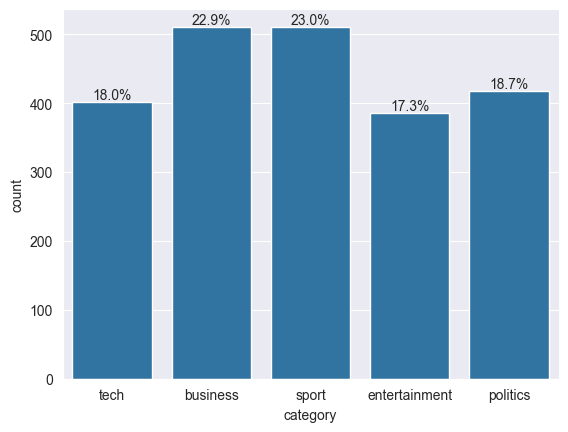

In [10]:
ax=sns.countplot(x=df['category'], data = df)
total = len(df['category'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

One hot encoding the category column

In [11]:
# Convert category column into numerical format
# ohe = OneHotEncoder()
# X_category = ohe.fit_transform(df[["category"]])

Apply TF IDF  to  the dataset to convert the text data into numerical

In [12]:
vectorizer = TfidfVectorizer(
    lowercase=True,        # make everything lowercase (default=True)
    stop_words='english',  # remove English stopwords (or give your own list)
    max_df=0.8,            # ignore words that appear in >80% of docs
    min_df=3,              # ignore words that appear in <3 docs
    ngram_range=(1,2)      # use unigrams and bigrams ("machine", "machine learning")
)

In [13]:
# convert text column into numerical format
X_text = vectorizer.fit_transform(df['text'])

In [14]:
# # Merge both the sparse matrices = text + category
# X_merged = hstack((X_text, X_category))
X_merged = X_text

Elbow Method

In [15]:
# Step 1 : Use elbow method to get the optimal number of clusters.
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_merged).fit(X_merged)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

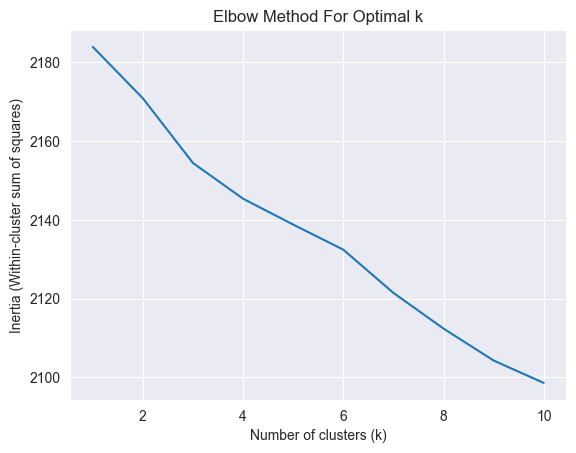

In [16]:
K = range(1,11)
plt.plot(K, inertia)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.title("Elbow Method For Optimal k")

Dimensionality reduction with PCA

In [17]:
pca = PCA(n_components=2) # 2 is the number of dimensions

In [18]:
X_reduced = pca.fit_transform(X_merged.toarray())

K Means Clustering

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)

.fit runs the kmeans algorithm on your data and finds centroids<br>
predict assigns all the data points to one of the cluster centroids

In [20]:
labels = kmeans.fit_predict(X_merged)
centers_reduced = pca.transform(kmeans.cluster_centers_)

kmeans.cluster_centers_ are the centroids in the original high-dimensional space (same dimension as TF-IDF features).

To plot them on the same 2D scatter plot, you must reduce them into the same 2D PCA space.

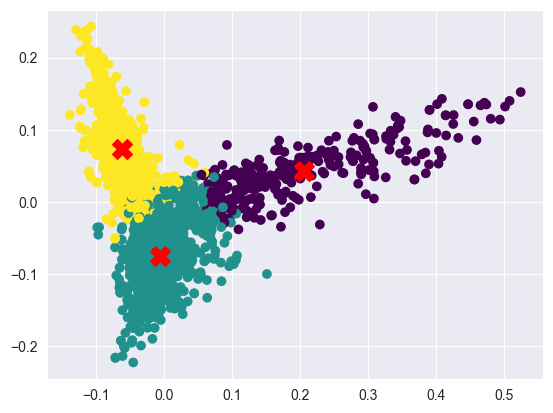

In [21]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap='viridis')
plt.scatter(centers_reduced[:,0], centers_reduced[:,1],
            s=200, c='red', marker='X')
plt.show()

<h4>Interpret clusters (find themes)</h4>
Right now you only have cluster IDs (0,1,2,…). You need to interpret what each cluster means.<br>
Extract top keywords per cluster from kmeans.cluster_centers_ (using the TF-IDF vocabulary).<br>
Look at those words → they’ll give you the "theme" of the cluster.<br>
Example:
- Cluster 0 → ["team", "match", "score", "player"] → Sports
- Cluster 1 → ["stock", "market", "company", "profit"] → Business
- Cluster 2 → ["government", "policy", "law", "parliament"] → Politics

In [23]:
# Get feature (word) names from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

In [24]:
# For each cluster, find top 10 words
def get_top_words_per_cluster(kmeans, terms, n_words=10):
    top_words = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        # Get indices of top n words in this cluster center
        top_indices = center.argsort()[-n_words:][::-1]
        top_words[i] = [terms[j] for j in top_indices]
    return top_words

In [25]:
top_words = get_top_words_per_cluster(kmeans, terms, n_words=10)

In [26]:
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 0: mr, labour, election, blair, party, brown, government, mr blair, howard, mr brown
Cluster 1: mr, people, year, market, new, company, mobile, firm, growth, sales
Cluster 2: film, best, game, year, england, win, won, play, world, time


<h3>Silhouette Score</h3>

In [33]:
score = silhouette_score(X_merged, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.008


This silhouette score indicates that the clusters are overlapping and not separated well

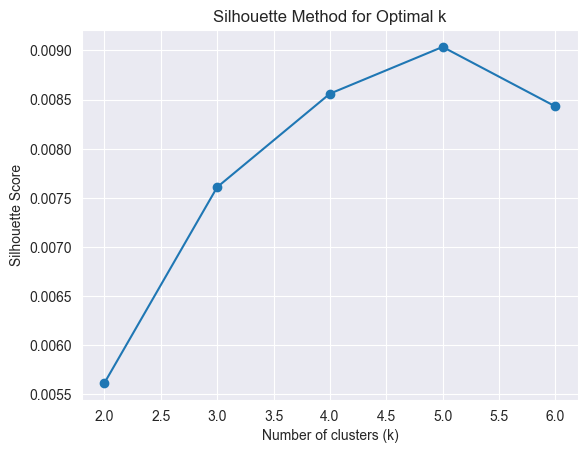

In [34]:
scores = []
K = range(2, 7)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_merged)
    score = silhouette_score(X_merged, labels)
    scores.append(score)

plt.plot(K, scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()


We have to choose that value of k where the silhouette score is maximized which is 5